In [23]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
orig_train_data = pd.read_csv("data/train_2008.csv")
train_data = orig_train_data.copy()

orig_test_data = pd.read_csv("data/test_2008.csv")
test_data = orig_test_data.copy()

In [3]:
train_data_orig_cols = list(orig_train_data.columns) # original columns, with target PES1 on the end
target_var = orig_train_data['PES1']
train_data.drop('PES1', axis=1, inplace=True)

# Drop bad columns

In [4]:
# Collect all features that are bad and need to be dropped
allocation_flag_feats = ['PRCITFLG', 'PRWERNAL', 'PRHERNAL', 'HXTENURE', 'HXHOUSUT', 
                         'HXTELHHD', 'HXTELAVL', 'HXPHONEO']
allocation_flag_feats.extend([col for col in train_data.columns if col[:2] == 'PX'])

recode_feats = ["PRFAMNUM","PRFAMREL","PRFAMTYP","PRPERTYP","PEMLR","PRDISC",
                "PRJOBSEA","PRWNTJOB","PRCOW1","PRCOW2","PRDTCOW1","PRDTCOW2","PRDTIND1",
                "PRDTIND2","PRDTOCC1","PRDTOCC2","PREMP","PRMJIND1","PRMJIND2","PRMJOCC1",
                "PRMJOCC2","PRNAGPWS","PRNAGWS","PRERNHLY","PRERNWA",
                "PRIMIND1","PRIMIND2","PRTFAGE","PTHR","PTWK","PTOT",]

one_answer_feats = ['HRMONTH', 'HRYEAR4', 'HUBUSL3', 'HUBUSL4', 'PULAYAVR', 'PULKDK2', 
                    'PULKDK3', 'PULKDK4', 'PULKDK5', 'PULKDK6', 'PULKPS2', 'PULKPS3', 
                    'PULKPS4', 'PULKPS5', 'PULKPS6', 'PUDWCK3', 'PUJHDP1O', 'PUERNH1C', 
                    'PTHR', 'PUERN2', 'PTOT',]
for feat in train_data.columns:
    if len(train_data[feat].unique()) == 1:
        one_answer_feats.append(feat)
        
bad_feats = ['QSTNUM', 'PRERNWA', 'PRERNHLY', 'PEERNH1O', 'HRHHID2', 'GTCSA', 'GTCO', 'id', 
             'HUINTTYP', 'HURESPLI', 'HRMIS', 'PRDTOCC1', 'PRFAMREL', 'PUSLFPRX', 'OCCURNUM',
             'PULINENO', 'PRMJOCC1', 'PRCHLD', 'GTCBSA', 'HRLONGLK', 'PEIO1OCD', 'PEIO2OCD',]

weight_feats = [col for col in train_data.columns if col[-3:] == 'WGT']

# We're deleting all columns that have <1% response rate; negative values indicate a
# nonresponse.
response_rates = train_data[train_data >= 0].count() / len(train_data)
mostly_blank_feats = []
for itm in response_rates.items():
    if itm[1] < 0.01:
        mostly_blank_feats.append(itm[0])



# Put them all together, and remove duplicates
feats_to_drop = list(set(allocation_flag_feats + recode_feats + one_answer_feats + 
                         bad_feats + weight_feats))

In [5]:
len(allocation_flag_feats)

104

In [6]:
# Drop the bad columns
train_data.drop(feats_to_drop, axis=1, inplace=True)
test_data.drop(feats_to_drop, axis=1, inplace=True)

In [7]:
len(train_data.columns) == len(test_data.columns)

True

In [8]:
(train_data.columns == test_data.columns).all()

True

In [9]:
train_data['PES1'] = target_var

In [13]:
train_data.to_csv("data/train_data_bad_cols_dropped_only.csv", index=False)

# Handle Categorical Features

In [10]:
categorical_feats = ['GEREG', 'HUBUS', 'PTDTRACE', 'PENATVTY', 'PUABSOT', 'PEIO1COW', 
                     'HUFINAL', 'GESTCEN', 'GESTFIPS', 'PEIO1ICD', 'PEIO2ICD', 
                     'PRCITSHP', 'PUDIS', 'PRABSREA', 'PRWKSTAT', 'HUPRSCNT', 
                     'PERRP', 'GTCBSAST', 'PRMJOCGR', 'HRHTYPE', ]

In [11]:
# First map all the nonresponses (<0) to -1.
for feat in categorical_feats:
    train_data[feat] = train_data[feat].apply(lambda x: -1 if x < 0 else x)
    test_data[feat] = test_data[feat].apply(lambda x: -1 if x < 0 else x)

In [12]:
# We'll do some manual segmenting on the features that indicate participant's industry

# First we need to map the values to industries
def convert_code_to_industry(x):
    if x == -1:
        return 'n/a'
    elif x >= 170 and x <= 290:
        return 'agri'
    elif x >= 370 and x <= 490:
        return 'mining'
    elif x >= 570 and x <= 690:
        return 'utilities'
    elif x == 770:
        return 'construction'
    elif x >= 1070 and x <= 2390:
        return 'nondur_manu'
    elif x >= 2470 and x <= 3990:
        return 'dur_manu'
    elif x >= 4070 and x <= 4290:
        return 'dur_wholesale_trade'
    elif x >= 4370 and x <= 4590:
        return 'nondur_wholesale_trade'
    elif x >= 4670 and x <= 5790:
        return 'retail_trade'
    elif x >= 6070 and x <= 6390:
        return 'transport'
    elif x >= 6470 and x <= 6780:
        return 'information'
    elif x >= 2470 and x <= 3990:
        return 'dur_manu'
    elif x >= 4070 and x <= 4290:
        return 'dur_wholesale_trade'
    elif x >= 4370 and x <= 4590:
        return 'nondur_wholesale_trade'
    elif x >= 6870 and x <= 6990:
        return 'fin_insurance'
    elif x >= 7070 and x <= 7190:
        return 'real_estate'
    elif x >= 7270 and x <= 7490:
        return 'tech_service'
    elif x == 7570:
        return 'comp_mgmnt'
    elif x >= 7580 and x <= 7790:
        return 'admin_supp_waste_service'
    elif x >= 7860 and x <= 7890:
        return 'edu_service'
    elif x >= 7970 and x <= 8470:
        return 'healthcare'
    elif x >= 8560 and x <= 8590:
        return 'art_enter_rec'
    elif x >= 8660 and x <= 8690:
        return 'accom_food_service'
    elif x >= 8770 and x <= 9290:
        return 'other_service'
    elif x >= 9370 and x <= 9590:
        return 'public_admin'
    elif x == 9890:
        return 'armed_forces'
    else:
        print(x)
        raise ValueError("No match for industry")

In [13]:
# Now use this function to relabel the industry features
train_data['PEIO1ICD'] = train_data['PEIO1ICD'].apply(convert_code_to_industry)
train_data['PEIO2ICD'] = train_data['PEIO2ICD'].apply(convert_code_to_industry)
test_data['PEIO1ICD'] = test_data['PEIO1ICD'].apply(convert_code_to_industry)
test_data['PEIO2ICD'] = test_data['PEIO2ICD'].apply(convert_code_to_industry)

In [14]:
# Now dummy these features
train_dummy_df = pd.DataFrame()
test_dummy_df = pd.DataFrame()

for var in categorical_feats:
    train_dummy_vars = pd.get_dummies(train_data[var], prefix=var)
    train_dummy_df = pd.concat([train_dummy_df, train_dummy_vars], axis=1)
    
    test_dummy_vars = pd.get_dummies(test_data[var], prefix=var)
    test_dummy_df = pd.concat([test_dummy_df, test_dummy_vars], axis=1)
    
# Drop the original categorical variables
train_data.drop(categorical_feats, axis=1, inplace=True)
test_data.drop(categorical_feats, axis=1, inplace=True)

In [15]:
# Add dummy vars to the data
train_data = pd.concat([train_data, train_dummy_df], axis=1)
test_data = pd.concat([test_data, test_dummy_df], axis=1)

In [16]:
# Now the train and test data have different numbers of features -> fix it!
feats_to_add_to_train = [f for f in test_data.columns if f not in train_data.columns]
feats_to_add_to_test = [f for f in train_data.columns if f not in test_data.columns 
                        and f != 'PES1']

for feat in feats_to_add_to_train:
    train_data[feat] = 0
for feat in feats_to_add_to_test:
    test_data[feat] = 0

# Handle Numerical Features

In [17]:
numerical_features = [f for f in train_data.columns if '_' not in f 
                      and f not in categorical_feats]
numerical_features.extend([f for f in test_data.columns if '_' not in f 
                      and f not in categorical_feats])

In [18]:
# First map all the nonresponses (<0) to -1.
for feat in numerical_features:
    train_data[feat] = train_data[feat].apply(lambda x: -1 if x < 0 else x)
    test_data[feat] = test_data[feat].apply(lambda x: -1 if x < 0 else x)

KeyError: 'PES1'

# A Few More Touchups

In [21]:
# Make sure columns are in the same order
test_data = test_data[train_data.columns]

In [22]:
### VERY IMPORTANT: Add the target feature back to the training data
train_data['PES1'] = target_var

# Write Out the Raw Features

In [23]:
# A couple checks first
assert train_data.columns[-1] == 'PES1'
assert len(train_data.columns) == len(test_data.columns) + 1
assert (train_data.columns[:-1] == test_data.columns).all()
len(train_data.columns)

623

In [164]:
train_data.to_csv("data/train_2008_back_to_basics.csv", index=False)
test_data.to_csv("data/test_2008_back_to_basics.csv", index=False)

# Optional: Feature Selection

In [26]:
train_data.drop('PES1', axis=1, inplace=True)

In [27]:
# Fit a classifier for evaluating most important features
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train_data.ix[:, :-1], target_var)

In [28]:
# Make a dataframe of the features and their importances
features = pd.DataFrame()
features['feature'] = train_data.columns[:-1]
features['importance'] = clf.feature_importances_

In [32]:
import pickle as pkl
pkl.dump(list(features.index), open('importance_scores_x_axis.pkl', 'wb'))

In [33]:
pkl.dump(list(features.sort(['importance'],ascending=False)['importance']), open('importance_scores_y_axis.pkl', 'wb'))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [35]:
a = pkl.load(open('importance_scores_x_axis.pkl', 'rb'))
b = pkl.load(open('importance_scores_y_axis.pkl', 'rb'))

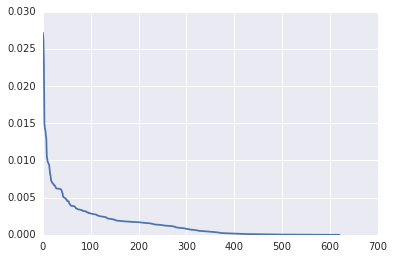

In [36]:
plt.plot(a,b)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


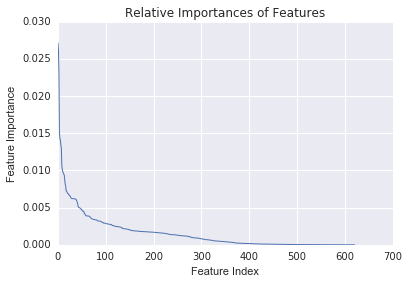

In [29]:
plt.plot(features.index, features.sort(['importance'],ascending=False)['importance'], linewidth=1.0)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Relative Importances of Features')
#plt.savefig('feature_importances.png')

In [30]:
# Take a look at the most important features
features.sort(['importance'],ascending=False).head(30)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
20,PEEDUCA,0.027133
15,PEAGE,0.026096
6,HUFAMINC,0.022860
1,HETENURE,0.015121
8,HRNUMHOU,0.014250
13,GTCBSASZ,0.014104
158,PEDIPGED,0.013425
160,PECYC,0.012988
161,PEGRPROF,0.010655
602,PRMJOCGR_1,0.010139


In [9]:

for thresh in [1.0]:
    # Pull out the most important features
    model = SelectFromModel(clf, prefit=True, threshold=str(thresh) + '*mean')
    train_data_selected_feats = model.transform(train_data.ix[:, :-1])
    print(train_data_selected_feats.shape)

    # Add the target back to the training data
    train_data_selected_feats = pd.DataFrame(train_data_selected_feats)
    train_data_selected_feats['targ'] = target_var

    # Write out the data sets
    train_data_selected_feats.to_csv("data/train_data_cutoff_" + str(thresh) + "mean.csv", index=False)

(64667, 112)


In [137]:
train_data_selected_feats.shape

(64667, 212)

In [138]:
# Kinda hacky, but we need some way of getting just the selected features in the test set (selecting features kills
# the column names).
imp_mean = features.importance.mean()
keep_feats = []
for f in features['feature']:
    if float(features[features['feature'] == f]['importance']) >= 1.0 * imp_mean:
        keep_feats.append(f)

In [141]:
len(keep_feats)

212

In [140]:
# Keep hacking....
keep_feats = [f for f in keep_feats if f in test_data.columns]

In [142]:
# Finally get the features we need
train_data_selected_feats = train_data[keep_feats]
test_data_selected_feats = test_data[keep_feats]

# Add the target back to the training data
train_data_selected_feats['targ'] = target_var

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
# Write out the data sets
train_data_selected_feats.to_csv("data/train_2008_back_to_basics_selected_feats.csv", index=False)
test_data_selected_feats.to_csv("data/test_2008_back_to_basics_selected_feats.csv", index=False)

In [145]:
len(test_data_selected_feats.columns)

212

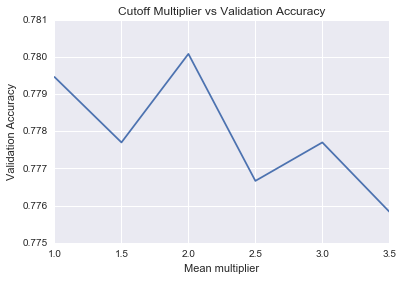

In [40]:
threshs = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
vals = [.779456, .777697, .780077, .776663, .777697, .775835]
plt.plot(threshs, vals)
plt.xlabel("Mean multiplier")
plt.ylabel("Validation Accuracy")
plt.title("Cutoff Multiplier vs Validation Accuracy")
plt.savefig("muliplier_vs_val_acc.png")